# ML for Nuclear Data: A Supervised Learning Starting Point

This notebook trains and evaluates two classical supervised-learning models
-- a Decision Tree and an XGBoost ensemble -- on neutron-induced
cross-section data from the EXFOR database.

### Why nuclear data?

Nuclear cross sections describe the probability of a reaction occurring
when a neutron strikes a target nucleus. They depend on:

- **Energy** -- cross sections vary over many orders of magnitude as
  incident energy changes from thermal (~0.01 eV) to fast (~20 MeV).
- **Isotope** (Z, A) -- each target nucleus has a different cross-section
  curve.
- **Reaction channel** (MT code) -- fission, capture, elastic scattering,
  (n,p), etc. each have distinct energy dependences.

The EXFOR database aggregates experimental measurements from laboratories
worldwide. Individual datasets vary in energy coverage, resolution, and
reported uncertainties, making cross-section prediction a heterogeneous
regression problem.

### Supervised learning setup

| | |
|---|---|
| **Inputs (features)** | Z, A, N, Energy, particle-emission vector, AME2020 nuclear properties |
| **Target** | Cross section $\sigma$ (barns) |
| **Training set** | Full EXFOR database (all isotopes, neutron-induced) |
| **Evaluation isotopes** | U-233 total XS (data-rich) and Cl-35 (n,p) (data-sparse) |

### What this notebook covers

- **Data loading** -- EXFOR measurements filtered to neutron-induced
  reactions in the 0.01 eV -- 20 MeV range, with configurable feature tiers.
- **Baseline models** -- Decision Tree and XGBoost, each with Bayesian
  hyperparameter search so that results reflect tuned performance.
- **Evaluation** -- predictions plotted against EXFOR data;
  feature-importance analysis.
- **Interpretation guidance** -- what the metrics and plots show, and what
  to look for when reading the results.


In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from nucml_next.data import NucmlDataset
from nucml_next.baselines import XGBoostEvaluator, DecisionTreeEvaluator

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Verify EXFOR data exists
exfor_path = Path('../data/exfor_test.parquet')
if not exfor_path.exists():
    raise FileNotFoundError(
        f"EXFOR data not found at {exfor_path}\n"
        "Please run: python scripts/ingest_exfor.py --x4-db data/x4sqlite1.db --output data/exfor_processed.parquet"
    )

print("✓ Imports successful")
print("✓ EXFOR data found")
print("Welcome to NUCML-Next: Understanding ML Limitations with Real Nuclear Data")

✓ Imports successful
✓ EXFOR data found
Welcome to NUCML-Next: Understanding ML Limitations with Real Nuclear Data


## Configuration

The cell below sets three groups of options that control the rest of the
notebook:

1. **Feature tiers** -- which AME2020 / NUBASE2020 nuclear-property columns
   to include alongside the core coordinates (Z, A, N, Energy) and
   particle-emission vector.
2. **Transformation pipeline** -- log-scaling for energy and cross section,
   optional feature standardisation.
3. **Uncertainty weighting** -- whether to weight training samples by
   inverse measurement uncertainty, and how to handle missing values.

All settings are defined once here; every subsequent cell reads from these
variables.


In [ ]:
# ============================================================================
# USER CONFIGURATION: Feature Tiers and Transformations
# ============================================================================
# Change these settings in ONE place instead of scattered throughout the notebook

from nucml_next.data.selection import TransformationConfig

# ============================================================================
# FEATURE TIER SELECTION
# ============================================================================
# Choose which AME2020/NUBASE2020 enrichment tiers to include
#
# Tier A (13 features) - ALWAYS INCLUDED:
#   - Z, A, N, Energy (nuclear coordinates)
#   - 9-feature Numerical Particle Vector:
#     out_n, out_p, out_a, out_g, out_f, out_t, out_h, out_d, is_met
#
# Tier B (+2 features) - Geometric:
#   + R_fm (nuclear radius)
#   + kR (dimensionless interaction parameter)
#
# Tier C (+7 features) - Energetics: RECOMMENDED FOR BASELINES
#   + Mass_Excess_MeV (mass excess)
#   + Binding_Energy_MeV (total binding energy)
#   + Binding_Per_Nucleon_MeV (B/A)
#   + S_1n_MeV, S_2n_MeV (neutron separation energies)
#   + S_1p_MeV, S_2p_MeV (proton separation energies)
#
# Tier D (+9 features) - Topological:
#   + Spin, Parity (nuclear structure)
#   + Isomer_Level, Half_Life_log10_s (log10-transformed half-life)
#   + Valence_N, Valence_P (distance to magic numbers)
#   + P_Factor (pairing: even-even/odd-odd)
#   + Shell_Closure_N, Shell_Closure_P
#
# Tier E (+8 features) - Complete Q-values:
#   + Q_alpha_MeV, Q_2beta_minus_MeV, Q_ep_MeV, etc.
#   + All 8 reaction Q-values from AME2020

SELECTED_TIERS = ['A', 'C']  # Change tiers HERE (only place to modify)

print(f"Selected Feature Tiers: {SELECTED_TIERS}")
print(f"   Features: Tier A (core + particle vector) + Tier C (energetics)")
print()

# ============================================================================
# TRANSFORMATION CONFIGURATION
# ============================================================================
# Configure log-scaling and feature scaling for ML training.
#
# ORDER OF OPERATIONS (forward transform):
#   1. Log-transform cross-section: sigma' = log10(sigma + epsilon)
#   2. Log-transform energy:        E' = log10(E)
#   3. Scale ALL features:          X' = (X - min) / (max - min)
#
# This ensures the scaler sees compressed log-space values rather than
# raw multi-order-of-magnitude physical values.
#
# For tree-based models (Decision Trees, XGBoost), feature scaling is NOT
# mathematically necessary because trees only use value ordering.
# However, MinMax scaling is cheap and doesn't hurt -- and it prepares
# the pipeline for neural networks where scaling IS required.

TRANSFORMATION_CONFIG = TransformationConfig(
    # ============================================================================
    # Target (cross-section) transformations
    # ============================================================================
    log_target=True,              # Enable log10 transform for cross-sections
                                  # Stabilizes gradients and handles wide range (ub to kb)
    
    target_epsilon=1e-10,         # Epsilon for log(xs + epsilon) to prevent log(0)
                                  # Increase if you have very small cross-sections
    
    log_base=10,                  # Logarithm base: 10 | 'e' | 2
                                  # Base-10 is standard in nuclear physics
    
    # ============================================================================
    # Energy transformations
    # ============================================================================
    log_energy=True,              # Enable log10 transform for energies
                                  # Handles wide energy range (eV to MeV)
    
    energy_log_base=10,           # Energy log base: 10 | 'e' | 2
    
    # ============================================================================
    # Feature standardization (MinMax, Z-score, etc.)
    # ============================================================================
    # Order: Log-transforms are applied FIRST, then feature scaling.
    # The scaler is fitted on log-transformed values, so Energy in the
    # scaler's view is log10(E), not raw eV.
    
    scaler_type='minmax',         # Feature scaling method:
                                  # 'minmax'   = Min-max scaling to [0,1] [DEFAULT]
                                  # 'standard' = Z-score normalization (X-mu)/sigma
                                  # 'robust'   = Robust scaling using median and IQR
                                  # 'none'     = No scaling
    
    scale_features='all',         # Which columns to scale:
                                  # 'all'  = Scale every numeric column [DEFAULT]
                                  # None   = Auto-detect numeric columns (same as 'all')
                                  # List   = Explicit column names, e.g. ['Z', 'A', 'Energy']
)

print("Transformation Configuration:")
print(TRANSFORMATION_CONFIG)
print()
print("NOTE: MinMax scaling applied to ALL features AFTER log-transforms.")
print("      Trees are scale-invariant, but this prepares the pipeline")
print("      for neural networks and doesn't hurt tree performance.")
print()

# ============================================================================
# UNCERTAINTY WEIGHTING CONFIGURATION
# ============================================================================
# Configure how to use experimental uncertainties during training.
#
# The EXFOR database contains measurement uncertainties for ~66% of cross-section
# values. These uncertainties can be used to weight samples during training,
# giving more influence to precise measurements and less to uncertain ones.
#
# Statistical basis: Inverse-variance weighting (w_i = 1/sigma_i^2) is the
# optimal weighting for least-squares regression when errors are heteroscedastic.

USE_UNCERTAINTY_WEIGHTS = 'xs'    # Uncertainty weighting mode:
                                  # None   = No weighting (equal weight)
                                  # 'xs'   = Weight by cross-section uncertainty (1/sigma_xs^2)
                                  # 'both' = Weight by XS AND energy uncertainty
                                  #          (1/sigma_xs^2 * 1/sigma_E^2)

MISSING_UNCERTAINTY_HANDLING = 'exclude'
                                  # How to handle samples with missing uncertainties
                                  # (only used when USE_UNCERTAINTY_WEIGHTS is not None):
                                  # 'median'  = Assign median weight from valid samples (default)
                                  # 'equal'   = Assign weight of 1.0
                                  # 'exclude' = Exclude samples without valid uncertainty
                                  #             (equivalent to requiring uncertainty)

print("=" * 80)
print("Uncertainty Weighting Configuration:")
print(f"  USE_UNCERTAINTY_WEIGHTS:       {USE_UNCERTAINTY_WEIGHTS}")
print(f"  MISSING_UNCERTAINTY_HANDLING:  '{MISSING_UNCERTAINTY_HANDLING}'")
if USE_UNCERTAINTY_WEIGHTS:
    print(f"\n  NOTE: Uncertainty weighting enabled (mode='{USE_UNCERTAINTY_WEIGHTS}').")
    print("        Samples with lower uncertainty get higher weight.")
    if MISSING_UNCERTAINTY_HANDLING == 'exclude':
        print("\n  NOTE: MISSING_UNCERTAINTY_HANDLING='exclude' will filter to only")
        print("        samples with valid uncertainty (~66% of data).")
print()
print("To change settings, modify SELECTED_TIERS and TRANSFORMATION_CONFIG above")
print("=" * 80)

## Outlier Detection & Interactive Threshold Selection

The ingested Parquet contains outlier detection results (if `--outlier-method` 
was used during ingestion). Two methods are available:

**Local MAD method (recommended):**
- Fits a smooth mean on pooled data per (Z, A, MT) group
- Computes energy-local MAD (median absolute deviation) of residuals
- Flags individual points with z > threshold as point outliers
- Flags entire experiments where a high fraction of points exceed threshold
- Columns: `experiment_outlier`, `point_outlier`, `z_score`, `experiment_id`

**Legacy SVGP method:**
- Pools all experiments per (Z, A, MT) group
- Point-level z-scores only

The interactive explorer below lets you browse any (Z, A, MT) group, 
visualise the z-score distribution, adjust the z-score threshold, 
and see how inlier/outlier counts change in real time.

If the Parquet does **not** contain outlier columns, this section is skipped
automatically and all data is retained.

In [ ]:
# ── Interactive Outlier Threshold Explorer ────────────────────────────────────
# Select any (Z, A, MT) group, adjust the z-score threshold, and inspect
# the smooth mean fit + z-score bands interactively.

EXFOR_DATA_PATH = '../data/exfor_processed.parquet'
ENDF_DIR = '../data/ENDF-B/neutrons'


# Check for outlier detection columns (supports both local MAD and SVGP methods)
_check_cols = ['z_score', 'experiment_outlier', 'experiment_id', 'point_outlier']
try:
    import pyarrow.parquet as pq
    pq_file = pq.ParquetFile(EXFOR_DATA_PATH)
    _available_cols = pq_file.schema.names
    _cols_to_load = [c for c in _check_cols if c in _available_cols]
    if _cols_to_load:
        _raw_check = pd.read_parquet(EXFOR_DATA_PATH, columns=_cols_to_load)
    else:
        _raw_check = pd.DataFrame()
except Exception:
    _raw_check = pd.DataFrame()

has_outlier_data = 'z_score' in _raw_check.columns and _raw_check['z_score'].notna().any()
has_experiment_outlier = 'experiment_outlier' in _raw_check.columns

if has_outlier_data:
    print("=" * 80)
    print("OUTLIER DETECTION DATA FOUND")
    print("=" * 80)
    
    if has_experiment_outlier:
        print("Method: Local MAD (smooth mean + energy-local MAD)")
        print("  - point_outlier: individual measurements with z > threshold")
        print("  - experiment_outlier: experiments with high fraction of flagged points")
        print("  - z_score: |deviation from consensus| / local scatter")
        print()
        print("Use 'Color by experiment' toggle to visualize individual experiments")
        print("Discrepant experiments are marked with red X markers")
    else:
        print("Method: Legacy SVGP (point-level only)")
        print("  - z_score: deviation from pooled SVGP fit")
    
    print("=" * 80)
    print()
    
    from nucml_next.visualization.threshold_explorer import ThresholdExplorer
    explorer = ThresholdExplorer(EXFOR_DATA_PATH, endf_dir=ENDF_DIR)
    explorer.show()
else:
    print("Outlier columns not found -- run ingestion with --outlier-method to enable")
    print("  Local MAD (recommended):      --outlier-method local_mad")
    print("  Legacy SVGP:                  --outlier-method svgp")
    print("\nProceeding without outlier filtering.\n")

# Store for use in cell 6
_HAS_EXPERIMENT_OUTLIER = has_experiment_outlier
del _raw_check

In [ ]:
# ── Get filter settings from explorer ─────────────────────────────────────────
# The ThresholdExplorer provides interactive controls for:
#   - z-score threshold (slider)
#   - Exclude point outliers (checkbox)
#   - Exclude discrepant experiments (checkbox)
#
# After configuring the explorer above, run this cell to capture the settings.

# ============================================================================
# GET SETTINGS FROM EXPLORER
# ============================================================================
if has_outlier_data and 'explorer' in dir():
    # Get current settings from explorer checkboxes
    FILTER_SETTINGS = explorer.get_filter_settings()
    
    print("=" * 80)
    print("OUTLIER FILTER SETTINGS (from explorer)")
    print("=" * 80)
    print(f"  z_threshold:                    {FILTER_SETTINGS['z_threshold']}")
    print(f"  exclude_point_outliers:         {FILTER_SETTINGS['exclude_point_outliers']}")
    print(f"  exclude_discrepant_experiments: {FILTER_SETTINGS['exclude_discrepant_experiments']}")
    print()
    print("These settings will be applied when loading training data in the next cell.")
    print("To change settings, adjust the checkboxes in the explorer and re-run this cell.")
    print("=" * 80)
else:
    # Fallback: no outlier data or explorer not initialized
    FILTER_SETTINGS = {
        'z_threshold': None,
        'exclude_point_outliers': False,
        'exclude_discrepant_experiments': False,
    }
    print("=" * 80)
    print("OUTLIER FILTER SETTINGS")
    print("=" * 80)
    print("No outlier data available - all data will be used for training.")
    print("To enable outlier filtering, run ingestion with --outlier-method local_mad")
    print("=" * 80)

## Data: EXFOR-derived processed dataset

The notebook loads a Parquet file produced by the NUCML-Next ingestion
pipeline (`scripts/ingest_exfor.py`). A `DataSelection` object specifies
the selection constraints used here for consistency:

- **Projectile**: neutron only.
- **Energy range**: 1e-5 eV to 2e7 eV (thermal through fast reactor
  energies).
- **Reaction channels**: all physical MT codes, including bookkeeping
  channels (MT 0, 1, >= 9000).
- **Validity filter**: rows with NaN or non-positive cross sections are
  dropped so that log-transforms are well-defined.

The full training set contains all isotopes. Two evaluation isotopes are
loaded separately:

| Isotope | Reaction | Role |
|---------|----------|------|
| U-233 | Total XS (MT 1) | Data-rich: thousands of EXFOR points |
| Cl-35 | (n,p) (MT 103) | Data-sparse: tens of EXFOR points |

Comparing a data-rich and a data-sparse case illustrates how model
behaviour changes with measurement density.


In [ ]:
# ============================================================================
# DATA SELECTION & LOADING
# ============================================================================
# Physics-aware selection with predicate pushdown for efficient loading.

from nucml_next.data import DataSelection
from nucml_next.experiment import HoldoutConfig, ExperimentManager, compute_holdout_metrics

print("=" * 80)
print("DATA SELECTION & LOADING")
print("=" * 80)

# ============================================================================
# PHASE-SPACE HOLDOUT CONFIGURATION
# ============================================================================
# Define holdout rules to measure extrapolation accuracy on unseen data.
# Rules are AND-intersected within, OR-unioned across (any match => holdout).
#
# Supported keys:
#   Z, A            — isotope (int)
#   MT              — reaction channel (int or list)
#   energy_range    — (E_min, E_max) in eV
#   xs_range        — (XS_min, XS_max) in barns
#   Entry           — EXFOR Entry ID(s) (str or list)
#
# Examples (uncomment to enable):
#   {'Z': 92, 'A': 233}                         — hold out ALL U-233 data
#   {'Z': 92, 'A': 235, 'MT': 102,
#    'energy_range': (1e-3, 1.0)}               — U-235 capture in resonance region
#   {'MT': 18}                                  — hold out ALL fission data
#   {'xs_range': (1e-6, 1e-3)}                  — hold out low cross-section points

HOLDOUT_CONFIG = HoldoutConfig(rules=[
    # ── Uncomment rules below to enable holdout ──────────────────────────
    # {'Z': 92, 'A': 233},
    # {'Z': 92, 'A': 235, 'MT': 102, 'energy_range': (1e-3, 1.0)},
    # {'MT': 18},
])

holdout_config = HOLDOUT_CONFIG if HOLDOUT_CONFIG.rules else None

if holdout_config:
    print(f"\nPhase-Space Holdout: {len(holdout_config.rules)} rule(s)")
    print(holdout_config)
else:
    print("\nPhase-Space Holdout: DISABLED")

# ============================================================================
# OUTLIER FILTERING (from explorer settings in cell 6)
# ============================================================================
# These settings come from the ThresholdExplorer checkboxes
_z_threshold = FILTER_SETTINGS.get('z_threshold')
_exclude_point = FILTER_SETTINGS.get('exclude_point_outliers', False)
_exclude_exp = FILTER_SETTINGS.get('exclude_discrepant_experiments', False)

print(f"\nOutlier Filtering:")
print(f"  z_threshold:                    {_z_threshold}")
print(f"  exclude_point_outliers:         {_exclude_point}")
print(f"  exclude_discrepant_experiments: {_exclude_exp}")

# ============================================================================
# DATA SELECTION
# ============================================================================
training_selection = DataSelection(
    # ========================================================================
    # PROJECTILE SELECTION
    # ========================================================================
    projectile='neutron',          # Options: 'neutron' | 'all' | '<code>' | ['<code>', ...]
                                   # 'neutron' = Only neutron-induced reactions (alias for 'n')
                                   # 'all'     = All projectiles, no filtering
                                   # 'n'       = Neutrons only (same as 'neutron')
                                   # 'p'       = Protons only
                                   # 'd'       = Deuterons only
                                   # 'a'       = Alphas only
                                   # 'g'       = Photons (gamma) only
                                   # 't'       = Tritons only
                                   # 'he3'     = Helium-3 only
                                   # ['n','p'] = Neutrons + protons
                                   # ['n','a','d'] = Custom combination

    # ========================================================================
    # ENERGY RANGE (eV)
    # ========================================================================
    energy_min=1e-5,               # Minimum energy in eV (1e-5 = 0.01 eV, thermal neutrons)
    energy_max=2e7,                # Maximum energy in eV (2e7 = 20 MeV, reactor physics upper bound)
                                   # Common ranges:
                                   #   - Thermal: 1e-5 to 1 eV
                                   #   - Resonance: 1 to 1e4 eV
                                   #   - Fast: 1e4 to 2e7 eV (20 MeV)
                                   #   - High energy: up to 1e9 eV (1 GeV)

    # ========================================================================
    # REACTION (MT) MODE SELECTION
    # ========================================================================
    mt_mode='all_physical',        # Options:
                                   # 'reactor_core'   → Essential for reactor modeling
                                   #                    (MT 2, 4, 16, 18, 102, 103, 107)
                                   #
                                   # 'threshold_only' → Reactions with energy thresholds
                                   #                    (MT 16, 17, 103, 104, 105, 106, 107)
                                   #
                                   # 'fission_details'→ Fission breakdown channels
                                   #                    (MT 18, 19, 20, 21, 38)
                                   #
                                   # 'all_physical'   → All MT codes (subject to exclude_mt)
                                   #
                                   # 'custom'         → Use custom_mt_codes list (see below)

    # ========================================================================
    # MT EXCLUSION LIST
    # ========================================================================
    # Specific MT codes to exclude from the dataset.
    # Each entry is a literal MT number, EXCEPT that 9000 is a sentinel
    # meaning "exclude all MT >= 9000" (lumped covariance / residual production).
    #
    # Examples:
    #   exclude_mt=[0]           — exclude only MT 0 (undefined/non-standard)
    #   exclude_mt=[0, 9000]     — also remove all MT >= 9000
    #   exclude_mt=[]            — include everything (no exclusions)
    #   exclude_mt=None          — include everything (no exclusions)
    exclude_mt=[],                 # No exclusions — include MT 0, 1, and MT >= 9000

    exclude_spectrum_averaged=True, # Exclude MXW, SPA, FIS, AV, BRA, BRS, SDT, FST, TTA
                                    # These are spectrum-averaged (non-monoenergetic) data
                                    # where "Energy" = characteristic spectrum energy,
                                    # not the actual incident energy.
                                    # Set False to include all sf8 types.

    # ========================================================================
    # DATA VALIDITY
    # ========================================================================
    drop_invalid=True,             # Drop NaN or non-positive cross-sections
                                   # Essential for log-transform: log(σ) requires σ > 0
                                   # Prevents training instabilities

    # ========================================================================
    # PHASE-SPACE HOLDOUT
    # ========================================================================
    holdout_config=holdout_config, # HoldoutConfig with intersection/union rule logic
                                   # Replaces the legacy holdout_isotopes parameter
                                   # Set to None to disable holdout filtering

    # ========================================================================
    # AME2020/NUBASE2020 ENRICHMENT TIER SELECTION
    # ========================================================================
    tiers=SELECTED_TIERS,          # Using centralized tier configuration from cell 3
    transformation_config=TRANSFORMATION_CONFIG,  # Using centralized transformation config

    # ========================================================================
    # OUTLIER FILTERING (from explorer settings)
    # ========================================================================
    z_threshold=_z_threshold if _exclude_point else None,
    include_outliers=not _exclude_point,
    exclude_discrepant_experiments=_exclude_exp,
)

print("\n" + "-" * 80)
print("Training Selection:")
print(training_selection)

# ============================================================================
# LOAD DATASET
# ============================================================================
print("\n" + "-" * 80)
print("Loading dataset with predicate pushdown...")
dataset_full = NucmlDataset(
    data_path='../data/exfor_processed.parquet',
    mode='tabular',
    selection=training_selection,
)

# Retrieve holdout data (if configured)
df_holdout = dataset_full.get_holdout_data()
if df_holdout is not None:
    print(f"\n[OK] Holdout reserved: {len(df_holdout):,} points "
          f"({df_holdout.groupby(['Z','A']).ngroups} isotopes)")
else:
    print("\n[--] No holdout data")

# ============================================================================
# PROJECT TO TABULAR FORMAT
# ============================================================================
print("\n" + "-" * 80)
print("Projecting to tabular format (particle vector)...")
_extra_meta = ['Energy_Uncertainty'] if USE_UNCERTAINTY_WEIGHTS == 'both' else None
df_tier = dataset_full.to_tabular(extra_metadata=_extra_meta)

print(f"\n[OK] Training set: {len(df_tier):,} samples x {len(df_tier.columns)} columns")
print(f"     Energy range: {df_tier['Energy'].min():.2e} – {df_tier['Energy'].max():.2e} eV")

# ============================================================================
# UNCERTAINTY COVERAGE SUMMARY
# ============================================================================
if 'Uncertainty' in df_tier.columns:
    valid_unc = df_tier['Uncertainty'].notna() & (df_tier['Uncertainty'] > 0)
    pct = 100 * valid_unc.sum() / len(df_tier)
    print(f"     XS uncertainty: {valid_unc.sum():,} / {len(df_tier):,} ({pct:.1f}%)")

# ============================================================================
# FEATURE SUMMARY
# ============================================================================
print("\n" + "-" * 80)
print(f"Feature Tiers: {SELECTED_TIERS}")
TIER_NAMES = {'A': 'Core+Particle', 'B': 'Geometric', 'C': 'Energetics',
              'D': 'Topological', 'E': 'Q-values'}
for t in SELECTED_TIERS:
    print(f"  Tier {t}: {TIER_NAMES.get(t, 'Unknown')}")

# ============================================================================
# DATA DISTRIBUTION
# ============================================================================
print("\n" + "-" * 80)
print("Top 10 Isotopes:")
for (z, a), cnt in dataset_full.df.groupby(['Z', 'A']).size().nlargest(10).items():
    elem = {92:'U', 17:'Cl', 94:'Pu', 26:'Fe', 8:'O', 1:'H', 82:'Pb',
            6:'C', 13:'Al', 7:'N', 11:'Na', 79:'Au'}.get(z, f'Z{z}')
    print(f"  {elem}-{a:3d}: {cnt:>8,}")

print(f"\nTotal: {dataset_full.df.groupby(['Z','A']).ngroups} isotopes, "
      f"{dataset_full.df['MT'].nunique()} MT codes, {len(dataset_full.df):,} points")

# ============================================================================
# LOAD EVALUATION ISOTOPES (U-233, Cl-35)
# ============================================================================
print("\n" + "-" * 80)
print("Loading evaluation targets (U-233, Cl-35)...")
eval_selection = DataSelection(
    projectile='neutron',
    energy_min=training_selection.energy_min,
    energy_max=training_selection.energy_max,
    mt_mode=training_selection.mt_mode,
    exclude_mt=training_selection.exclude_mt,
    exclude_spectrum_averaged=True,
    drop_invalid=True,
    tiers=SELECTED_TIERS,
)

dataset_eval = NucmlDataset(
    data_path='../data/exfor_processed.parquet',
    mode='tabular',
    selection=eval_selection,
)
dataset_eval.df = dataset_eval.df[
    ((dataset_eval.df['Z'] == 92) & (dataset_eval.df['A'] == 233)) |
    ((dataset_eval.df['Z'] == 17) & (dataset_eval.df['A'] == 35))
].copy()

print(f"[OK] Evaluation set: {len(dataset_eval.df):,} points")
for (z, a), grp in dataset_eval.df.groupby(['Z', 'A']):
    iso = 'U' if z == 92 else 'Cl'
    print(f"     {iso}-{a}: {len(grp):,} (MT: {sorted(grp['MT'].unique())})")
print("=" * 80)

### Feature representation

Reaction channels (MT codes) are encoded as a 9-component
**particle-emission vector** (`out_n`, `out_p`, `out_a`, ..., `is_met`)
rather than one-hot indicators. This preserves information about which
particles are emitted in each reaction.

If Tier C is selected, seven AME2020 energetics columns (mass excess,
binding energies, separation energies) are appended. The full set of
available tiers is documented in the configuration cell above.


## Baseline 1 -- Decision Tree

A single Decision Tree is trained on the full EXFOR dataset. To ensure the
results reflect a well-tuned model rather than arbitrary defaults, Bayesian
hyperparameter optimisation (hyperopt with TPE) is run first, and the best
parameters are then used to train on the complete training set.

A Decision Tree partitions feature space into axis-aligned rectangles,
returning a constant prediction within each rectangle. The resulting
cross-section curve is therefore piecewise constant by construction.


In [ ]:
# ============================================================================
# HYPERPARAMETER OPTIMIZATION FOR DECISION TREE
# ============================================================================
# Find good hyperparameters using one of the available search strategies.
# The final model is always retrained on FULL data with the best parameters.

# ============================================================================
# USER CONFIGURATION: Hyperparameter Search Space
# ============================================================================

# ============================================================================
# OPTIMIZATION METHOD SELECTION
# ============================================================================
# Choose the hyperparameter search strategy:
#
# 'bayesian' (RECOMMENDED):
#   - Uses Tree-structured Parzen Estimator (TPE) via hyperopt
#   - Most sample-efficient; learns from previous evaluations
#   - Best for expensive model evaluations and complex parameter interactions
#   - Requires: pip install hyperopt
#
# 'grid':
#   - Exhaustive search over all parameter combinations
#   - Guaranteed to find optimum within the grid
#   - Time complexity: O(n^k) - exponential in number of parameters
#   - Best for: Small search spaces where exhaustive search is feasible
#
# 'random':
#   - Randomly samples parameter combinations
#   - Typically finds good solutions faster than grid search
#   - Good for: Large search spaces, continuous parameters
#
# 'halving':
#   - Successive halving strategy (HalvingRandomSearchCV)
#   - Progressively eliminates poor candidates using data subsets
#   - Much faster than full random search on large datasets
#   - Requires: sklearn >= 0.24

DT_OPTIMIZATION_METHOD = 'bayesian'  # Options: 'bayesian' | 'grid' | 'random' | 'halving'

# max_depth: Maximum tree depth
DT_MIN_DEPTH = 60
DT_MAX_DEPTH = 90
DT_DEPTH_STEP = 2          # choices: 60, 62, 64, ..., 90

# min_samples_split: Minimum samples required to split an internal node
DT_MIN_MSS = 2
DT_MAX_MSS = 16
DT_MSS_STEP = 2            # choices: 2, 4, 6, ..., 16

# min_samples_leaf: Minimum samples required at a leaf node
DT_MIN_MSL = 1
DT_MAX_MSL = 12
DT_MSL_STEP = 1            # choices: 1, 2, 3, ..., 12

# min_impurity_decrease: Minimum impurity decrease required for a split.
# Default 0.0 means no regularization via impurity threshold.
# When subsampling for hyperparameter search, absolute impurity thresholds
# found on subsampled data over-regularize on full data (e.g. depth 36,
# 1085 leaves on 8M samples). The structural params (max_depth, mss, msl)
# already control complexity and generalise correctly from subsample to
# full data. Set to a small positive value (e.g. 1e-7) only if you observe
# severe overfitting.
DT_MIN_IMPURITY_DECREASE = 0.0

# Bayesian search budget (only used when DT_OPTIMIZATION_METHOD = 'bayesian')
DT_MAX_EVALS = 200         # number of hyperopt trials

# ============================================================================
# VALIDATION STRATEGY
# ============================================================================
# How to evaluate candidate hyperparameters during the search.
#
# 'holdout' (default):
#   Splits data into train / val / test.
#   Each hyperopt trial trains on "train" and evaluates on "val".
#   The final model is retrained on train+val and scored on the "test" set.
#   Faster and simpler -- recommended for large datasets.
#
# 'kfold':
#   Each hyperopt trial runs k-fold CV on the train+val portion.
#   The final model is retrained on train+val and scored on a held-out test set.
#   More robust estimate of generalisation but k-times slower per trial.

DT_VALIDATION_METHOD = 'holdout'   # 'holdout' or 'kfold'

# Holdout split percentages (must sum to 1.0)
DT_TRAIN_FRACTION = 0.70          # 70% for training during search
DT_VAL_FRACTION   = 0.15          # 15% for validation during search
DT_TEST_FRACTION  = 0.15          # 15% held out for final evaluation

# K-fold settings (only used when DT_VALIDATION_METHOD = 'kfold')
DT_CV = 3                         # number of cross-validation folds

# Data subsampling for hyperparameter search
# The full dataset can be millions of rows. Running cross-validated hyperopt
# on all of it is slow. Subsampling uses a random fraction for the search,
# then the final model is retrained on the FULL dataset with the best params.
DT_SUBSAMPLE_FRACTION = 0.1    # fraction of data for search (0.1 = 10%)
DT_SUBSAMPLE_MAX = 1_000_000   # hard cap on subsample size

# ============================================================================
# BUILD SEARCH SPACE FROM SETTINGS
# ============================================================================
DT_DEPTH_OPTIONS = list(range(DT_MIN_DEPTH, DT_MAX_DEPTH + 1, DT_DEPTH_STEP))
DT_MSS_OPTIONS = list(range(DT_MIN_MSS, DT_MAX_MSS + 1, DT_MSS_STEP))
DT_MSL_OPTIONS = list(range(DT_MIN_MSL, DT_MAX_MSL + 1, DT_MSL_STEP))
DT_MSS_RANGE = (DT_MIN_MSS, DT_MAX_MSS)
DT_MSL_RANGE = (DT_MIN_MSL, DT_MAX_MSL)

print("=" * 80)
print("DECISION TREE HYPERPARAMETER OPTIMIZATION")
print("=" * 80)
print(f"Optimization:")
print(f"  method:                {DT_OPTIMIZATION_METHOD}")
print(f"Search space:")
print(f"  max_depth:             {DT_MIN_DEPTH} to {DT_MAX_DEPTH} (step {DT_DEPTH_STEP}) -> {len(DT_DEPTH_OPTIONS)} choices")
print(f"  min_samples_split:     {DT_MIN_MSS} to {DT_MAX_MSS} (step {DT_MSS_STEP}) -> {len(DT_MSS_OPTIONS)} choices")
print(f"  min_samples_leaf:      {DT_MIN_MSL} to {DT_MAX_MSL} (step {DT_MSL_STEP}) -> {len(DT_MSL_OPTIONS)} choices")
print(f"  min_impurity_decrease: {DT_MIN_IMPURITY_DECREASE} (fixed)")
if DT_OPTIMIZATION_METHOD == 'bayesian':
    print(f"  max_evals:             {DT_MAX_EVALS}")
print(f"Validation:")
print(f"  method:                {DT_VALIDATION_METHOD}")
if DT_VALIDATION_METHOD == 'holdout':
    print(f"  split:                 train={DT_TRAIN_FRACTION:.0%} / val={DT_VAL_FRACTION:.0%} / test={DT_TEST_FRACTION:.0%}")
else:
    print(f"  cv folds:              {DT_CV}")
print(f"Subsampling:")
print(f"  fraction:              {DT_SUBSAMPLE_FRACTION*100:.0f}% (max {DT_SUBSAMPLE_MAX:,})")
print("=" * 80)

# ============================================================================
# RUN HYPERPARAMETER OPTIMIZATION
# ============================================================================
dt_optimizer = DecisionTreeEvaluator()

opt_result_dt = dt_optimizer.optimize_hyperparameters(
    df_tier,
    method=DT_OPTIMIZATION_METHOD,
    max_evals=DT_MAX_EVALS,
    cv_folds=DT_CV,
    verbose=True,
    transformation_config=TRANSFORMATION_CONFIG,
    max_depth_options=DT_DEPTH_OPTIONS,
    min_samples_split_range=DT_MSS_RANGE,
    min_samples_leaf_range=DT_MSL_RANGE,
    min_impurity_decrease=DT_MIN_IMPURITY_DECREASE,
    subsample_fraction=DT_SUBSAMPLE_FRACTION,
    subsample_max_samples=DT_SUBSAMPLE_MAX,
    # Validation strategy
    validation_method=DT_VALIDATION_METHOD,
    train_fraction=DT_TRAIN_FRACTION,
    val_fraction=DT_VAL_FRACTION,
    test_fraction=DT_TEST_FRACTION,
    # Uncertainty-based sample filtering
    use_uncertainty_weights=USE_UNCERTAINTY_WEIGHTS,
    missing_uncertainty_handling=MISSING_UNCERTAINTY_HANDLING,
)

# ============================================================================
# TRAIN FINAL MODEL WITH OPTIMAL HYPERPARAMETERS ON FULL DATA
# ============================================================================
print("\n" + "=" * 80)
print("TRAINING FINAL MODEL WITH OPTIMAL HYPERPARAMETERS")
print("=" * 80)

print(f"\nUncertainty Weighting:")
print(f"  use_uncertainty_weights:      {USE_UNCERTAINTY_WEIGHTS}")
print(f"  missing_uncertainty_handling: '{MISSING_UNCERTAINTY_HANDLING}'")
print()

dt_model = DecisionTreeEvaluator(**opt_result_dt['best_params'])
dt_metrics = dt_model.train(
    df_tier,
    transformation_config=TRANSFORMATION_CONFIG,
    use_uncertainty_weights=USE_UNCERTAINTY_WEIGHTS,
    missing_uncertainty_handling=MISSING_UNCERTAINTY_HANDLING,
)

# ============================================================================
# PHASE-SPACE HOLDOUT EVALUATION (Decision Tree)
# ============================================================================
dt_holdout_metrics = None
if df_holdout is not None and len(df_holdout) > 0:
    dt_holdout_metrics = compute_holdout_metrics(
        dt_model, df_holdout, dt_model.pipeline)
    print("\n" + "=" * 80)
    print("PHASE-SPACE HOLDOUT METRICS (Decision Tree)")
    print("=" * 80)
    for k, v in dt_holdout_metrics.items():
        if isinstance(v, float):
            print(f"  {k:30s}: {v:.6f}")
        else:
            print(f"  {k:30s}: {v}")
    print("=" * 80)
else:
    print("\n[--] Holdout evaluation skipped (no holdout data)")

### Decision Tree predictions

The plots below overlay the Decision Tree's predictions on actual EXFOR
data points for two evaluation isotopes.

- **U-233 total XS** (data-rich): many training points are available for
  this isotope/reaction.
- **Cl-35 (n,p)** (data-sparse): the model relies on patterns learned from
  other isotopes to fill gaps in energy coverage.


In [ ]:
# ============================================================================
# VISUALIZATION: Decision Tree predictions on evaluation isotopes
# ============================================================================
# IsotopePlotter handles all data filtering, prediction generation, and
# plotting in a single call.  Just specify Z, A, MT.

from nucml_next.visualization import IsotopePlotter

# Energy range for all plots
E_MIN_PLOT = 1e-4   # 10^-4 eV
E_MAX_PLOT = 1e7    # 10^7 eV

df_plot = df_tier

# ── Filter to z_score-assessed points (match explorer) ──────────────────────
# The ThresholdExplorer only shows points with a valid z_score.
# Points without z_score (groups too small for MAD computation) may include
# un-assessed outliers.  Drop them so the scatter matches the explorer.
if 'z_score' in dataset_full.df.columns:
    _scored_idx = dataset_full.df.index[dataset_full.df['z_score'].notna()]
    _n_before = len(df_plot)
    df_plot = df_plot.loc[df_plot.index.isin(_scored_idx)]
    _n_dropped = _n_before - len(df_plot)
    if _n_dropped > 0:
        print(f"[z_score filter] Removed {_n_dropped:,} unscored points "
              f"({_n_before:,} \u2192 {len(df_plot):,})")

# ── Combine training + holdout for visualization ─────────────────────────────
if df_holdout is not None and len(df_holdout) > 0:
    df_plot_all = pd.concat([df_plot, df_holdout], ignore_index=True)
    print(f"[Holdout included] Combined {len(df_plot):,} training + "
          f"{len(df_holdout):,} holdout = {len(df_plot_all):,} total for plotting")
else:
    df_plot_all = df_plot

# Create plotter (ENDF_DIR defined in cell 5)
plotter_dt = IsotopePlotter(
    training_df=df_plot_all,
    models={'Decision Tree': dt_model},
    energy_range=(E_MIN_PLOT, E_MAX_PLOT),
    endf_dir=ENDF_DIR,
)

# U-233 Total XS (data-rich)
plotter_dt.plot(Z=92, A=233, MT=1)

# Cl-35 (n,p) (data-sparse)
plotter_dt.plot(Z=17, A=35, MT=103)

### How Decision Trees produce predictions

A Decision Tree recursively splits on feature thresholds:

```
if Energy < 10.5:
    if Energy < 5.2:
        return 150.0   # constant within this leaf
    else:
        return 89.0    # discontinuous jump at boundary
else:
    return 45.0
```

Each leaf returns a single value, so the predicted cross-section curve is a
step function regardless of how the tree is tuned. Compare this with the
smooth Breit-Wigner form that describes resonance peaks in nuclear
cross sections:

$$\sigma(E) = \sigma_0 \frac{\Gamma}{(E - E_r)^2 + \Gamma^2/4}$$

---

## Baseline 2 -- XGBoost

XGBoost builds an ensemble of shallow decision trees via gradient boosting.
Because many trees contribute to each prediction, the resulting curve is
a sum of many step functions -- still piecewise constant, but with finer
steps.

The same Bayesian hyperparameter search strategy is applied here.


In [ ]:
# ============================================================================
# HYPERPARAMETER OPTIMIZATION FOR XGBOOST
# ============================================================================
# Find good hyperparameters using Bayesian optimization (hyperopt TPE).
# Consistent with the Decision Tree approach: min/max ranges, subsampling,
# and final retrain on FULL data with the best parameters.

# ============================================================================
# USER CONFIGURATION: Hyperparameter Search Space
# ============================================================================

# n_estimators: Number of boosting rounds (trees in the ensemble)
XGB_MIN_ESTIMATORS = 100
XGB_MAX_ESTIMATORS = 300

# max_depth: Maximum depth of each tree (shallower than single DT)
XGB_MIN_DEPTH = 4
XGB_MAX_DEPTH = 10

# learning_rate (eta): Step size shrinkage to prevent overfitting
XGB_LR_MIN = 0.01
XGB_LR_MAX = 0.2

# subsample: Fraction of training samples used per tree
XGB_SUBSAMPLE_MIN = 0.7
XGB_SUBSAMPLE_MAX_FRAC = 1.0

# Bayesian search budget
XGB_MAX_EVALS = 100         # number of hyperopt trials

# Data subsampling for hyperparameter search
XGB_SUBSAMPLE_FRACTION = 0.1    # 10% of data for search
XGB_SUBSAMPLE_MAX = 1_000_000   # hard cap on subsample size

print("=" * 80)
print("XGBOOST HYPERPARAMETER OPTIMIZATION")
print("=" * 80)
print(f"Search space:")
print(f"  n_estimators:    {XGB_MIN_ESTIMATORS} to {XGB_MAX_ESTIMATORS}")
print(f"  max_depth:       {XGB_MIN_DEPTH} to {XGB_MAX_DEPTH}")
print(f"  learning_rate:   {XGB_LR_MIN} to {XGB_LR_MAX}")
print(f"  subsample:       {XGB_SUBSAMPLE_MIN} to {XGB_SUBSAMPLE_MAX_FRAC}")
print(f"Optimization:")
print(f"  method:          bayesian (hyperopt TPE)")
print(f"  max_evals:       {XGB_MAX_EVALS}")
print(f"Subsampling:")
print(f"  fraction:        {XGB_SUBSAMPLE_FRACTION*100:.0f}% (max {XGB_SUBSAMPLE_MAX:,})")
print("=" * 80)

# ============================================================================
# RUN HYPERPARAMETER OPTIMIZATION
# ============================================================================
xgb_optimizer = XGBoostEvaluator()

opt_result_xgb = xgb_optimizer.optimize_hyperparameters(
    df_tier,
    max_evals=XGB_MAX_EVALS,
    verbose=True,
    transformation_config=TRANSFORMATION_CONFIG,
    n_estimators_range=(XGB_MIN_ESTIMATORS, XGB_MAX_ESTIMATORS),
    max_depth_range=(XGB_MIN_DEPTH, XGB_MAX_DEPTH),
    learning_rate_range=(XGB_LR_MIN, XGB_LR_MAX),
    subsample_range=(XGB_SUBSAMPLE_MIN, XGB_SUBSAMPLE_MAX_FRAC),
    subsample_fraction=XGB_SUBSAMPLE_FRACTION,
    subsample_max_samples=XGB_SUBSAMPLE_MAX,
    # Uncertainty-based sample filtering
    use_uncertainty_weights=USE_UNCERTAINTY_WEIGHTS,
    missing_uncertainty_handling=MISSING_UNCERTAINTY_HANDLING,
)

best_params_xgb = opt_result_xgb['best_params']

# ============================================================================
# TRAIN FINAL MODEL WITH OPTIMAL HYPERPARAMETERS ON FULL DATA
# ============================================================================
print("\n" + "=" * 80)
print("TRAINING FINAL MODEL WITH OPTIMAL HYPERPARAMETERS")
print("=" * 80)

print(f"\nUncertainty Weighting:")
print(f"  use_uncertainty_weights:      {USE_UNCERTAINTY_WEIGHTS}")
print(f"  missing_uncertainty_handling: '{MISSING_UNCERTAINTY_HANDLING}'")
print()

xgb_model = XGBoostEvaluator(**best_params_xgb)
xgb_metrics = xgb_model.train(
    df_tier,
    transformation_config=TRANSFORMATION_CONFIG,
    use_uncertainty_weights=USE_UNCERTAINTY_WEIGHTS,
    missing_uncertainty_handling=MISSING_UNCERTAINTY_HANDLING,
)

# ============================================================================
# PHASE-SPACE HOLDOUT EVALUATION (XGBoost)
# ============================================================================
xgb_holdout_metrics = None
if df_holdout is not None and len(df_holdout) > 0:
    xgb_holdout_metrics = compute_holdout_metrics(
        xgb_model, df_holdout, xgb_model.pipeline)
    print("\n" + "=" * 80)
    print("PHASE-SPACE HOLDOUT METRICS (XGBoost)")
    print("=" * 80)
    for k, v in xgb_holdout_metrics.items():
        if isinstance(v, float):
            print(f"  {k:30s}: {v:.6f}")
        else:
            print(f"  {k:30s}: {v}")
    print("=" * 80)
else:
    print("\n[--] Holdout evaluation skipped (no holdout data)")

In [ ]:
# ============================================================================
# XGBoost vs Decision Tree Comparison
# ============================================================================
# Both models on the same plot for direct visual comparison.

from nucml_next.visualization import IsotopePlotter

plotter_compare = IsotopePlotter(
    training_df=df_plot_all,
    models={'Decision Tree': dt_model, 'XGBoost': xgb_model},
    energy_range=(E_MIN_PLOT, E_MAX_PLOT),
    endf_dir=ENDF_DIR,
)

# U-233 Total XS — both models overlaid
plotter_compare.plot(
    Z=92, A=233, MT=1,
    title='XGBoost vs Decision Tree\nU-233 Total XS (Model trained on full EXFOR)',
)

## Baseline 3 -- Simple Neural Network

A small feedforward neural network trained on the same features as the tree
models.  Unlike trees, a neural network can produce smooth (continuous)
predictions because it composes differentiable activation functions.

This cell offers three loss functions to compare:

| Loss | Formula | Use case |
|------|---------|----------|
| **MSE** | $\frac{1}{N}\sum(y_i - \hat{y}_i)^2$ | Standard regression baseline |
| **Chi-squared** | $\frac{1}{N}\sum\frac{(y_i - \hat{y}_i)^2}{\sigma_i^2}$ | Weights by measurement precision |
| **Physics-informed** | MSE + $\lambda_\text{smooth}\cdot\|\nabla\hat{\sigma}\|$ | Penalises unphysical oscillations |

The network is deliberately small (2 hidden layers) so that training time is
comparable to the tree baselines.  The goal is not state-of-the-art accuracy
but rather to illustrate the difference in prediction character (smooth vs
piecewise constant).

In [ ]:
# ============================================================================
# BASELINE 3: SIMPLE NEURAL NETWORK
# ============================================================================
# A small feedforward network comparable to the DT and XGB baselines.
# Trains on the same transformed features and targets.
#
# LOSS FUNCTION OPTIONS:
#   'mse'              — Standard mean squared error
#   'chi_squared'      — Weighted MSE using inverse uncertainty (chi²/N)
#   'physics_informed' — MSE + smoothness penalty on dσ/dE

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from nucml_next.data.transformations import TransformationPipeline

# ============================================================================
# USER CONFIGURATION
# ============================================================================
NN_LOSS_FUNCTION = 'mse'          # 'mse' | 'chi_squared' | 'physics_informed'
NN_HIDDEN_SIZES = [128, 64]       # Hidden layer widths
NN_EPOCHS = 80                    # Training epochs
NN_BATCH_SIZE = 4096              # Mini-batch size
NN_LEARNING_RATE = 1e-3           # Adam learning rate
NN_SMOOTHNESS_WEIGHT = 0.01      # Lambda for physics-informed smoothness term
NN_TEST_FRACTION = 0.15           # Held-out test fraction

print("=" * 80)
print("NEURAL NETWORK BASELINE")
print("=" * 80)
print(f"  Loss function:   {NN_LOSS_FUNCTION}")
print(f"  Hidden layers:   {NN_HIDDEN_SIZES}")
print(f"  Epochs:          {NN_EPOCHS}")
print(f"  Batch size:      {NN_BATCH_SIZE}")
print(f"  Learning rate:   {NN_LEARNING_RATE}")
if NN_LOSS_FUNCTION == 'physics_informed':
    print(f"  Smoothness λ:    {NN_SMOOTHNESS_WEIGHT}")
print("=" * 80)

# ============================================================================
# PREPARE DATA (same pipeline as tree baselines)
# ============================================================================
exclude_columns = ['CrossSection', 'Uncertainty', 'Energy_Uncertainty', 'Entry', 'MT']
numeric_cols = df_tier.select_dtypes(include=[np.number]).columns.tolist()
nn_feature_columns = [col for col in numeric_cols if col not in exclude_columns]

X_feat = df_tier[nn_feature_columns]
y_raw = df_tier['CrossSection']
energy_raw = df_tier['Energy']

nn_pipeline = TransformationPipeline(config=TRANSFORMATION_CONFIG)
nn_pipeline.fit(X_feat, y_raw, energy_raw, feature_columns=nn_feature_columns)

X_t = nn_pipeline.transform(X_feat, energy_raw)
y_t = nn_pipeline.transform_target(y_raw)

X_np = X_t[nn_feature_columns].values.astype(np.float32)
y_np = y_t.values.astype(np.float32).reshape(-1, 1)

# Energy column (transformed) for physics-informed loss
energy_col_idx = nn_feature_columns.index('Energy')

# Uncertainty weights for chi-squared loss
if NN_LOSS_FUNCTION == 'chi_squared' and 'Uncertainty' in df_tier.columns:
    unc_raw = df_tier['Uncertainty'].values.astype(np.float32)
    # Transform uncertainty to log-space: delta(log sigma) ≈ delta_sigma / sigma
    xs_vals = df_tier['CrossSection'].values.astype(np.float32)
    unc_log = np.where(
        (np.isfinite(unc_raw)) & (unc_raw > 0) & (xs_vals > 0),
        unc_raw / (xs_vals * np.log(10) + 1e-30),   # d(log10 x) = dx/(x ln10)
        np.nan,
    )
else:
    unc_log = np.full(len(y_np), np.nan, dtype=np.float32)

# Drop invalid rows
valid = np.isfinite(X_np).all(axis=1) & np.isfinite(y_np.ravel())
if NN_LOSS_FUNCTION == 'chi_squared':
    valid &= np.isfinite(unc_log) & (unc_log > 0)
X_np, y_np, unc_log = X_np[valid], y_np[valid], unc_log[valid]
print(f"Valid samples: {valid.sum():,} / {len(valid):,}")

# Train/test split
from sklearn.model_selection import train_test_split as tts
idx_train, idx_test = tts(np.arange(len(X_np)), test_size=NN_TEST_FRACTION, random_state=42)

X_train_t = torch.from_numpy(X_np[idx_train])
y_train_t = torch.from_numpy(y_np[idx_train])
X_test_t  = torch.from_numpy(X_np[idx_test])
y_test_t  = torch.from_numpy(y_np[idx_test])
unc_train_t = torch.from_numpy(unc_log[idx_train])

train_ds = TensorDataset(X_train_t, y_train_t, unc_train_t)
train_dl = DataLoader(train_ds, batch_size=NN_BATCH_SIZE, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ============================================================================
# DEFINE NETWORK
# ============================================================================
class SimpleNet(nn.Module):
    def __init__(self, n_features, hidden_sizes):
        super().__init__()
        layers = []
        prev = n_features
        for h in hidden_sizes:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.BatchNorm1d(h)]
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

n_features = X_train_t.shape[1]
model_nn = SimpleNet(n_features, NN_HIDDEN_SIZES).to(device)
optimizer = torch.optim.Adam(model_nn.parameters(), lr=NN_LEARNING_RATE)
print(f"Parameters: {sum(p.numel() for p in model_nn.parameters()):,}")

# ============================================================================
# LOSS FUNCTIONS
# ============================================================================
def mse_loss(pred, target, **kw):
    return ((pred - target) ** 2).mean()

def chi_squared_loss(pred, target, unc=None, **kw):
    """Chi-squared / N: weight each residual by 1/sigma^2."""
    if unc is None or not torch.isfinite(unc).all():
        return mse_loss(pred, target)
    var = (unc ** 2).clamp(min=1e-12)
    return ((pred - target) ** 2 / var).mean()

def physics_informed_loss(pred, target, energy=None, lam=0.01, **kw):
    """MSE + smoothness penalty on dσ/dE (penalises unphysical oscillations).

    The smoothness term encourages the network to produce predictions that
    vary smoothly with energy — a basic physics prior since real cross
    sections are smooth functions of energy (even resonances have analytic
    Breit-Wigner shapes rather than discontinuities).
    """
    data_loss = ((pred - target) ** 2).mean()
    if energy is None:
        return data_loss
    # Sort by energy so finite differences approximate the derivative
    order = energy.argsort()
    pred_sorted = pred[order].squeeze()
    e_sorted = energy[order]
    dE = (e_sorted[1:] - e_sorted[:-1]).clamp(min=1e-12)
    dS = pred_sorted[1:] - pred_sorted[:-1]
    smoothness = (dS / dE).abs().mean()
    return data_loss + lam * smoothness

loss_fn = {
    'mse': mse_loss,
    'chi_squared': chi_squared_loss,
    'physics_informed': physics_informed_loss,
}[NN_LOSS_FUNCTION]

# ============================================================================
# TRAINING LOOP
# ============================================================================
history = []
for epoch in range(1, NN_EPOCHS + 1):
    model_nn.train()
    epoch_loss = 0.0
    for xb, yb, ub in train_dl:
        xb, yb, ub = xb.to(device), yb.to(device), ub.to(device)
        pred = model_nn(xb)
        kwargs = {}
        if NN_LOSS_FUNCTION == 'chi_squared':
            kwargs['unc'] = ub
        elif NN_LOSS_FUNCTION == 'physics_informed':
            kwargs['energy'] = xb[:, energy_col_idx]
            kwargs['lam'] = NN_SMOOTHNESS_WEIGHT
        loss = loss_fn(pred, yb, **kwargs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(xb)
    epoch_loss /= len(idx_train)
    history.append(epoch_loss)
    if epoch % 20 == 0 or epoch == 1:
        print(f"  Epoch {epoch:3d}/{NN_EPOCHS}  loss={epoch_loss:.6f}")

# ============================================================================
# EVALUATE
# ============================================================================
model_nn.eval()
with torch.no_grad():
    y_pred_test = model_nn(X_test_t.to(device)).cpu().numpy().ravel()

# Inverse-transform predictions and targets back to barns
y_pred_barns = nn_pipeline.inverse_transform_target(pd.Series(y_pred_test)).values
y_true_barns = nn_pipeline.inverse_transform_target(pd.Series(y_np[idx_test].ravel())).values

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
nn_mse  = mean_squared_error(y_true_barns, y_pred_barns)
nn_mae  = mean_absolute_error(y_true_barns, y_pred_barns)
nn_r2   = r2_score(y_true_barns, y_pred_barns)

print(f"\nNeural Network ({NN_LOSS_FUNCTION}) — Test Metrics (barns):")
print(f"  MSE:  {nn_mse:.4e}")
print(f"  MAE:  {nn_mae:.4e}")
print(f"  R²:   {nn_r2:.4f}")
print("=" * 80)

# ============================================================================
# WRAP IN A PREDICT-COMPATIBLE OBJECT FOR IsotopePlotter
# ============================================================================
class _NNPredictor:
    """Thin wrapper so IsotopePlotter can call nn_model.predict(df)."""
    def __init__(self, net, pipeline, feature_columns, device):
        self.net = net
        self.pipeline = pipeline
        self.feature_columns = feature_columns
        self._device = device

    def predict(self, df, energy_column='Energy'):
        X = df[self.feature_columns]
        energy = df[energy_column] if energy_column in df.columns else None
        Xt = self.pipeline.transform(X, energy)
        arr = Xt[self.feature_columns].values.astype(np.float32)
        arr = np.nan_to_num(arr, nan=0.0, posinf=1e10, neginf=-1e10)
        self.net.eval()
        with torch.no_grad():
            pred_t = self.net(torch.from_numpy(arr).to(self._device)).cpu().numpy().ravel()
        return self.pipeline.inverse_transform_target(pd.Series(pred_t)).values

nn_model = _NNPredictor(model_nn, nn_pipeline, nn_feature_columns, device)
print("Neural network wrapped as nn_model (has .predict() for IsotopePlotter)")

## All Models + ENDF/B Comparison

The plot below overlays all three baseline models (Decision Tree, XGBoost,
Neural Network) together with the ENDF/B-VIII.0 evaluated data and the raw
EXFOR experimental scatter.  This provides a single visual comparison of:

- **EXFOR scatter** -- experimental measurements with their scatter
- **ENDF/B-VIII.0** -- the authoritative evaluated library
- **Decision Tree** -- piecewise constant (staircase)
- **XGBoost** -- smoother piecewise constant (finer steps)
- **Neural Network** -- smooth continuous predictions

In [ ]:
# ============================================================================
# ALL MODELS + ENDF/B + EXFOR: COMBINED COMPARISON
# ============================================================================
# Plot all three baselines alongside ENDF/B-VIII.0 and EXFOR scatter
# for both evaluation isotopes.

from nucml_next.visualization import IsotopePlotter

plotter_all = IsotopePlotter(
    training_df=df_plot_all,
    models={
        'Decision Tree': dt_model,
        'XGBoost': xgb_model,
        'Neural Net': nn_model,
    },
    energy_range=(E_MIN_PLOT, E_MAX_PLOT),
    endf_dir=ENDF_DIR,
)

# ── U-233 Total XS (data-rich) ──────────────────────────────────────────────
plotter_all.plot(
    Z=92, A=233, MT=1,
    show_endf=True,
    title='All Baselines vs ENDF/B\nU-233 Total XS',
)

# ── Cl-35 (n,p) (data-sparse) ───────────────────────────────────────────────
plotter_all.plot(
    Z=17, A=35, MT=103,
    show_endf=True,
    title='All Baselines vs ENDF/B\nCl-35 (n,p)',
)

### Comparing Decision Tree and XGBoost

The comparison plot shows both models on U-233 total cross-section data.
You may observe that:

- XGBoost produces a smoother curve than the single Decision Tree because
  it averages hundreds of weak learners.
- Both models are piecewise constant by construction -- the underlying
  architecture does not enforce continuity or smoothness.

---

## Feature importance

XGBoost provides per-feature importance scores (gain-based). The bar chart
below shows which input features the model relies on most heavily when
making splits.


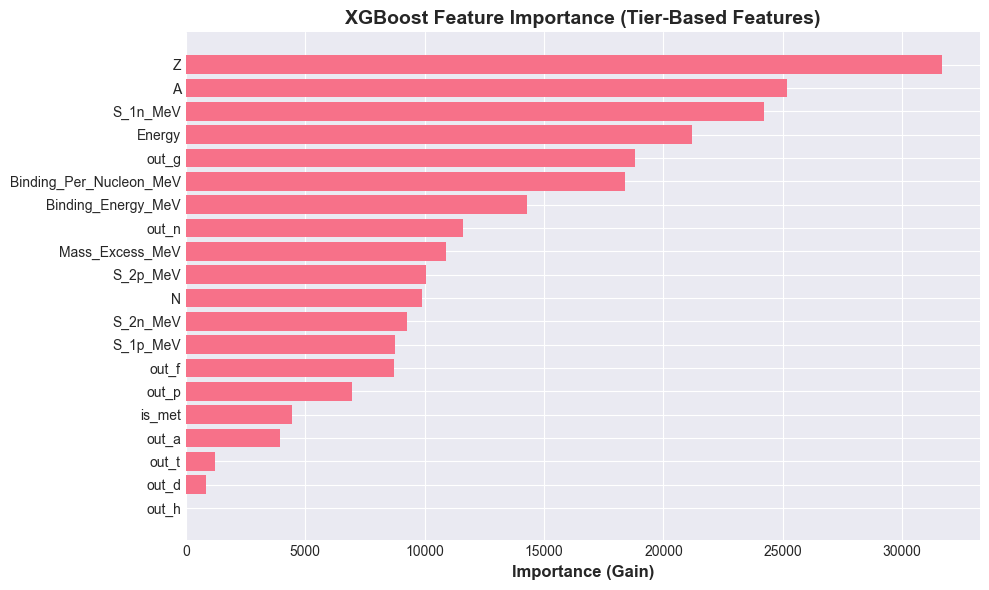


Top 5 Most Important Features:
     Feature    Importance
12         Z  31673.291016
14         A  25156.460938
15  S_1n_MeV  24204.935547
16    Energy  21177.593750
1      out_g  18813.681641


In [8]:
# Get feature importance
importance = xgb_model.get_feature_importance()

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance['Feature'], importance['Importance'])
ax.set_xlabel('Importance (Gain)', fontsize=12, fontweight='bold')
ax.set_title('XGBoost Feature Importance (Tier-Based Features)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(importance.head())

In [ ]:
# ============================================================================
# SAVE EXPERIMENTS (Optional)
# ============================================================================
# After reviewing the training results above, decide whether to save:
#   - Trained model files (.joblib)
#   - Scaler/pipeline artifacts
#   - Plots for each evaluation isotope
#
# Set SAVE_EXPERIMENTS = True to persist everything to disk.
# Experiments are saved to: experiments/<model>_<timestamp>/

SAVE_EXPERIMENTS = False  # Set to True to save models, scalers, and plots

if SAVE_EXPERIMENTS:
    from nucml_next.experiment import ExperimentManager
    
    exp_mgr = ExperimentManager()
    
    # ── Save Decision Tree experiment ────────────────────────────────────────
    print("=" * 80)
    print("SAVING DECISION TREE EXPERIMENT")
    print("=" * 80)
    
    dt_exp_dir = exp_mgr.save_experiment(
        model=dt_model,
        model_type='decision_tree',
        selection=training_selection,
        holdout_config=HOLDOUT_CONFIG if HOLDOUT_CONFIG.rules else None,
        holdout_metrics=dt_holdout_metrics,
        extra_metadata={
            'metrics': dt_metrics,
            'hyperopt_result': opt_result_dt,
            'transformation_config': str(TRANSFORMATION_CONFIG),
        },
    )
    print(f"[OK] Decision Tree saved to: {dt_exp_dir}")
    
    # Save Decision Tree plots
    plotter_dt_save = IsotopePlotter(
        training_df=df_plot_all,
        models={'Decision Tree': dt_model},
        energy_range=(E_MIN_PLOT, E_MAX_PLOT),
        experiment_dir=dt_exp_dir,
    )
    plotter_dt_save.plot(Z=92, A=233, MT=1)
    plotter_dt_save.plot(Z=17, A=35, MT=103)
    print(f"[OK] Decision Tree plots saved")
    
    # ── Save XGBoost experiment ──────────────────────────────────────────────
    print("\n" + "=" * 80)
    print("SAVING XGBOOST EXPERIMENT")
    print("=" * 80)
    
    xgb_exp_dir = exp_mgr.save_experiment(
        model=xgb_model,
        model_type='xgboost',
        selection=training_selection,
        holdout_config=HOLDOUT_CONFIG if HOLDOUT_CONFIG.rules else None,
        holdout_metrics=xgb_holdout_metrics,
        extra_metadata={
            'metrics': xgb_metrics,
            'hyperopt_result': {'best_params': best_params_xgb},
            'transformation_config': str(TRANSFORMATION_CONFIG),
        },
    )
    print(f"[OK] XGBoost saved to: {xgb_exp_dir}")
    
    # Save XGBoost plots
    plotter_xgb_save = IsotopePlotter(
        training_df=df_plot_all,
        models={'XGBoost': xgb_model},
        energy_range=(E_MIN_PLOT, E_MAX_PLOT),
        experiment_dir=xgb_exp_dir,
    )
    plotter_xgb_save.plot(Z=92, A=233, MT=1)
    plotter_xgb_save.plot(Z=17, A=35, MT=103)
    print(f"[OK] XGBoost plots saved")
    
    print("\n" + "=" * 80)
    print("ALL EXPERIMENTS SAVED SUCCESSFULLY")
    print("=" * 80)
else:
    print("SAVE_EXPERIMENTS = False")
    print("Set SAVE_EXPERIMENTS = True above and re-run this cell to save models and plots.")